# 一次元CNNの時系列解析

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

## とりあえずダミーデータ作成

#### これはノイズ除去用

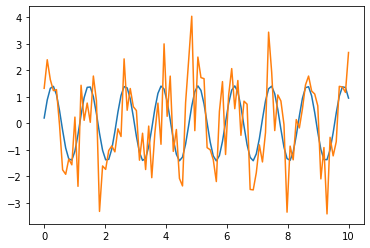

In [17]:
n_sample = 10000                           #作るサンプル数の指定
data_length = 100                          #作る時系列データの大きさ指定
time = 10                                  #作る時系列データの長さ指定

t = np.linspace(0,time,data_length)        #基準の時間軸生成
T = 1 + np.random.random((n_sample,1))*2   #時定数(周波数の逆数)を決める(T=[1,3))
A = 1 + np.random.random((n_sample,1))     #振幅を決める(A=[1,2))
_x = np.random.randn(n_sample,1)           #sin波平行移動用
y = A*np.sin((2*np.pi / T)*t.reshape(1,data_length) + _x)    #sin波を適当にn_sample作成(n_sample,data_length)
d = [np.random.randn(data_length) for i in range(n_sample)]  #外乱生成
y_origin = y        #教師データ
y_noise = y + d     #ノイズデータ

#二つだけプロット
plt.plot(t,y_origin[0])
plt.plot(t,y_noise[0])

#### これは異常検知用

In [193]:
"""
n_sample = 10000                           #作るサンプル数の指定
data_length = 100                          #作る時系列データの大きさ指定
time = 10                                  #作る時系列データの長さ指定

t = np.linspace(0,time,data_length)        #基準の時間軸生成
T = 1 + np.random.random((n_sample,1))*2   #時定数(周波数の逆数)を決める(T=[1,3))
A = 1 + np.random.random((n_sample,1))     #振幅を決める(A=[1,2))
_x = np.random.randn(n_sample,1)           #sin波平行移動用
y = A*np.sin((2*np.pi / T)*t.reshape(1,data_length) + _x)    #sin波を適当にn_sample作成(n_sample,data_length)
d = [np.random.randn(data_length)/4 for i in range(n_sample)]  #外乱生成
y_origin = y + d       #教師データ
label = [0]*n_sample       #ラベル

for i in range(n_sample):
    #ノイズの数を抑制する=>今回は1/4が異常
    if np.random.randint(0,3)==0:
        anomalie_start  = np.random.randint(0,89)
        anomalie_length = np.random.randint(5,10)
        y_origin[i][anomalie_start:anomalie_start+anomalie_length] += np.random.randn(anomalie_length)
        label[i] = 1
    else:
        pass

colum_list=[0]*n_sample
for i in range(n_sample):
    if label[i]==0:
        colum_list[i] = "Normal_wave_"+str(i)
    else:
        colum_list[i] = "Anormalie_wave_"+str(i)

    
DF = pd.DataFrame(y_origin.T,columns=colum_list)
DF.to_csv("anomlie_detection_train.csv")

#二つだけプロット
for i in range(3):
    plt.plot(t,y_origin[i])
    print(label[i])


"""

'\nn_sample = 10000                           #作るサンプル数の指定\ndata_length = 100                          #作る時系列データの大きさ指定\ntime = 10                                  #作る時系列データの長さ指定\n\nt = np.linspace(0,time,data_length)        #基準の時間軸生成\nT = 1 + np.random.random((n_sample,1))*2   #時定数(周波数の逆数)を決める(T=[1,3))\nA = 1 + np.random.random((n_sample,1))     #振幅を決める(A=[1,2))\n_x = np.random.randn(n_sample,1)           #sin波平行移動用\ny = A*np.sin((2*np.pi / T)*t.reshape(1,data_length) + _x)    #sin波を適当にn_sample作成(n_sample,data_length)\nd = [np.random.randn(data_length)/4 for i in range(n_sample)]  #外乱生成\ny_origin = y + d       #教師データ\nlabel = [0]*n_sample       #ラベル\n\nfor i in range(n_sample):\n    #ノイズの数を抑制する=>今回は1/4が異常\n    if np.random.randint(0,3)==0:\n        anomalie_start  = np.random.randint(0,89)\n        anomalie_length = np.random.randint(5,10)\n        y_origin[i][anomalie_start:anomalie_start+anomalie_length] += np.random.randn(anomalie_length)\n        label[i] = 1\n    else:\n        pas

#### これは未来予測用

In [191]:
"""
n_sample = 10000                           #作るサンプル数の指定
data_length = 300                          #作る時系列データの大きさ指定
time = 20                                  #作る時系列データの長さ指定

t = np.linspace(0,time,data_length)        #基準の時間軸生成
T = 1 + np.random.random((n_sample,1))*2   #時定数(周波数の逆数)を決める(T=[1,3))
A = 1 + np.random.random((n_sample,1))     #振幅を決める(A=[1,2))
_x = np.random.randn(n_sample,1)           #sin波平行移動用

t_1 = np.linspace(0,time,data_length)        #基準の時間軸生成
T_1 = 1 + np.random.random((n_sample,1))*3   #時定数(周波数の逆数)を決める(T=[1,3))
A_1 = (1 + np.random.random((n_sample,1)))     #振幅を決める(A=[1,2))
_x_1 = np.random.randn(n_sample,1)           #sin波平行移動用

y = A*np.sin((2*np.pi / T)*t.reshape(1,data_length) + _x)    #sin波を適当にn_sample作成(n_sample,data_length)
y_1 = A_1*np.sin((2*np.pi / T_1)*t.reshape(1,data_length) + _x_1)    #sin波を適当にn_sample作成(n_sample,data_length)

y+=y_1
y_origin = y[:1000,:100]        #教師データ
predict_wave = y[:,100:]


colum_list=[0]*1000
for i in range(1000):
    colum_list[i] = "Wave_"+str(i)

    
DF = pd.DataFrame(y_origin.T,columns=colum_list)
DF.to_csv("future_predict_test.csv")



#二つだけプロット
plt.plot(t[:100],y_origin[0])
plt.plot(t[100:],predict_wave[0])
"""

'\nn_sample = 10000                           #作るサンプル数の指定\ndata_length = 300                          #作る時系列データの大きさ指定\ntime = 20                                  #作る時系列データの長さ指定\n\nt = np.linspace(0,time,data_length)        #基準の時間軸生成\nT = 1 + np.random.random((n_sample,1))*2   #時定数(周波数の逆数)を決める(T=[1,3))\nA = 1 + np.random.random((n_sample,1))     #振幅を決める(A=[1,2))\n_x = np.random.randn(n_sample,1)           #sin波平行移動用\n\nt_1 = np.linspace(0,time,data_length)        #基準の時間軸生成\nT_1 = 1 + np.random.random((n_sample,1))*3   #時定数(周波数の逆数)を決める(T=[1,3))\nA_1 = (1 + np.random.random((n_sample,1)))     #振幅を決める(A=[1,2))\n_x_1 = np.random.randn(n_sample,1)           #sin波平行移動用\n\ny = A*np.sin((2*np.pi / T)*t.reshape(1,data_length) + _x)    #sin波を適当にn_sample作成(n_sample,data_length)\ny_1 = A_1*np.sin((2*np.pi / T_1)*t.reshape(1,data_length) + _x_1)    #sin波を適当にn_sample作成(n_sample,data_length)\n\ny+=y_1\ny_origin = y[:1000,:100]        #教師データ\npredict_wave = y[:,100:]\n\n\ncolum_list=[0]*1000\nfor i in 

## 訓練データとテストデータに分ける

In [18]:
X_train, X_test, y_train, y_test = train_test_split(y_noise,y_origin)
print("X_train => ",X_train.shape)
print("X_train => ",y_train.shape)
print("X_test => ",X_test.shape)
print("y_test => ",y_test.shape)


X_train_cnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_cnn  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)
print(X_test.shape)

X_train =>  (7500, 100)
X_train =>  (7500, 100)
X_test =>  (2500, 100)
y_test =>  (2500, 100)
(7500, 100)
(2500, 100)


## 必要そうなクラスと関数リスト

**最低限必要なLayer Class**
- 畳み込み層(Conv1d)
- 平滑化層(Flatten)
- 全結合出力層(Affin)
 - 回帰
 - 二値分類
 - 多値分類
- Pooling層

あればうれしい
- 全結合中間層(全結合出力層で一緒に作れる)←ifで制御？デフォルトの引数にy=Noneとかでいける？
- BatchNorm(ちょっとわかってない。全方向に対して？？)

### Optimizerのクラス群
- SGD
- Adagrad
- Adam
- Eve
- 最近提案されたやつ(Adaboundsとか？)

In [19]:
#SGD
class SGD:
    def __init__(self):
        pass
    
    def setting(self,in_shape, out_shape):
        """
        全結合層なので平滑化されている前提（バッチサイズ側にもやるっけ？）
        in_shape : 入力データの形
        out_shape: 出力データの形
        """
        self.w = np.random.randn(in_shape, out_shape)*np.sqrt(2/in_shape)    #w(入力サイズ,出力サイズ,)
        self.b = np.random.randn(out_shape)*np.sqrt(2/in_shape)              #b(出力サイズ,)
    
    def update(self,alpha,grad_w, grad_b):
        """
        alpha : 学習率(デフォルトは0.01)
        """
        self.w -= alpha*grad_w
        self.w -= alpha*grad_b

In [20]:
#Adagrad
class Adagrad:
    def __init__(self):
        pass
    
    def setting(self,in_shape, out_shape,kernel=None):
        """
        in_shape : 入力データの形
        out_shape: 出力データの形
        """
        #全結合層の時
        if type(in_shape) == int:
            self.w = np.random.randn(in_shape, out_shape)*np.sqrt(2/in_shape)    #w(入力サイズ,出力サイズ,)
            self.b = np.random.randn(out_shape)*np.sqrt(2/in_shape)              #b(出力サイズ,)
            self.H_w = np.zeros((in_shape, out_shape)) + 1e-8
            self.H_b = np.zeros(out_shape) + 1e-8
        #Conv1dの時
        elif type(kernel) == int:
            wb_width = in_shape[0]*in_shape[1]
            self.w = np.random.randn(out_shape[0],in_shape[0],kernel)*np.sqrt(2/wb_width)    #w(入力サイズ,出力サイズ,)
            self.b = np.random.randn(1,out_shape[0])*np.sqrt(2/wb_width)                     #b(1,出力チャンネル数,)
            self.H_w = np.zeros((out_shape[0],in_shape[0],kernel)) + 1e-8
            self.H_b = np.zeros(out_shape[0]) + 1e-8
        #Conv2dの時
        elif len(kernel) == 2:
            wb_width = in_shape[0]*in_shape[1]*in_shape[2]
            self.w = np.random.randn(out_shape[0],in_shape[0],kernel[0],kernel[1])*np.sqrt(2/wb_width)    #w(入力サイズ,出力サイズ,)
            self.b = np.random.randn(1,out_shape[0])*np.sqrt(2/wb_width)                                  #b(1,出力チャンネル数,)
            self.H_w = np.zeros((out_shape[0],in_shape[0],kernel[0],kernel[1])) + 1e-8
            self.H_b = np.zeros(out_shape[0]) + 1e-8
        else:
            pass
        
    def update(self,alpha, dw, db):
        """
        alpha : 学習率(デフォルトは0.01)
        """
        self.H_w += dw**2
        self.H_b += db**2
        
        self.w -= (alpha*dw) / np.sqrt(self.H_w)
        self.b -= (alpha*db) / np.sqrt(self.H_b)

### 活性化関数のクラス
- ReLU(Leakyも一緒にp=0~1を引数にして一緒にしてしまう)
- PReLU
- Tanh
- Sigmoid
- Softmax

In [21]:
#活性化関数（出力層に用いるときはp=1で恒等関数に）
class LeakyReLU:
    def __init__(self,a):
        #入力が負の時の傾きp=0~1
        self.a = a
        
    def forward(self,u):
        self.u = u
        return np.where(self.u <= 0, self.u*self.a, self.u)
    
    def backward(self):
        return np.where(self.u <= 0, self.a, 1)

In [22]:
class Tanh:
    def forward(self,u):
        self.u = u
        return np.tanh(self.u)
    
    def backward(self):
        return np.cosh(self.u)**(-2)

In [23]:
class Sigmoid:
    def forward(self,u):
        self.u = u
        return 1/(1 + np.exp(-self.u))
    
    def backward(self):
        return np.exp(-self.u)/(1 + np.exp(-self.u))**2

In [24]:
#出力層
class Softmax:
    def forward(self,u):
        self.u = u
        return np.exp(self.u)/np.sum(np.exp(self.u), axis=1)
    
    def backward(self):
        #活性化関数の外で誤差を計算するからいらない
        pass

#### 全結合層

In [25]:
#継承用クラス(平滑化前提)
##最終目標：最低限入力サイズと出力サイズを渡せばいいようにしたい
##なんなら入力サイズもなくしたい（前のレイヤーで自明に決まっているはずなので）
class Affine_Base:
    
    #activation=PReLU(p=0.),optimizer=Adam()で活性化関数や最適化手法を変更可能にする
    def __init__(self,in_shape,out_shape,kernel=None,alpha=0.01,activation=LeakyReLU(a=0.),optimizer=Adagrad()):
        self.alpha = alpha                             #学習率は Layer のインスタンスを作った時点で決めたいのでコンストラクタに渡しておく
        self.activation = activation
        self.optimizer = optimizer                     #Optimizer classをコンストラクタに渡してあげる
        self.optimizer.setting(in_shape, out_shape,kernel)    #この Layer の重みなど初期化(重みなどのparamaterを全結合層のselfに渡す)
    
    def update(self):
        self.optimizer.update(self.alpha, self.grad_w, self.grad_b)              #optimizerに最適化は任せてある

In [26]:
#全結合層
class FC(Affine_Base):
    def forward(self,X,y=[],loss_function="mse"):
        
        self.w = self.optimizer.w
        self.b = self.optimizer.b
        self.X = X
        self.t = y
        self.u = np.dot(self.X,self.w) + self.b
        self.loss_function = loss_function
        #出力を計算
        self.Y = self.activation.forward(self.u)
        return self.Y
    
    def backward(self,grad_y):
        #出力層のとき
        if len(self.t) != 0:
            delta = self.Y - self.t
        #中間層の時
        else:
            delta = grad_y*self.activation.backward()
        
        self.grad_w = np.dot(self.X.T, delta)
        self.grad_b = np.sum(delta,axis=0)
        self.grad_x = np.dot(delta,self.w.T)
        return self.grad_x
    
    def loss_func(self,X,y):
        #多値分類
        if self.loss_function == "softmax":
            loss = np.exp(self.u) / np.sum(np.exp(self.u), axis=1).reshape(-1,1)
        #二値分類
        elif self.loss_function == "sigmoid":
            loss = 1 / (1 + np.exp(-self.u))
        #回帰(恒等関数)
        elif self.loss_function == "mse":
            loss = np.sum((X-y)**2 / 2)
        else:
            pass
        
        return loss

#### Pooling層

In [27]:
class Pooling1D:
    def __init__(self, in_shape, out_shape, pool=2,pad=0):
        
        self.params = {}
        self.params["C_in"] = in_shape[0]
        self.params["C_out"] = out_shape[0]
        self.params["X_w"] = in_shape[1]
        self.params["Y_w"] = out_shape[1]
        self.params["K"] = pool
        self.params["stride"] = pool
        self.params["pad"] = pad
        
    def im2col(self,img):
        #各パラメータ(名前が長いので略記)
        C_in, C_out, X_w, Y_w, K, S, P = self.params.values()
        img_pad = np.pad(img,[(0,0),(0,0),(P,P)],"constant")  #時系列データ長さ側だけにpading
        col = np.zeros((self.B, C_in, K, Y_w))                  #(バッチサイズ,入力チャンネル数,カーネル幅,出力データの長さ)
        
        for w in range(K):
            col[:,:,w,:] = img_pad[:,:,w:w+S*Y_w:S]
            
        col = col.transpose(1,2,0,3).reshape(C_in*K,self.B*Y_w)      #(C_in,F_w,B,X_out)→(C_in*F_w,B*X_out)
        return col
    
    def col2im(self,col):
        #各パラメータ(名前が長いので略記)
        C_in, C_out, X_w, Y_w, K, S, P = self.params.values()
        
        col = col.reshape(C_in, K, self.B, Y_w)
        col = col.transpose(2, 0, 1, 3)
        img = np.zeros((self.B, C_in, X_w+2*P+S-1))
        
        for w in range(K):
            img[:,:,w:w+S*Y_w:S] += col[:,:,w,:]
        
        col = img[:,:, P:X_w+P]
        return col
    
    def forward(self,X):
        #各パラメータ(名前が長いので略記)
        C_in, C_out, X_w, Y_w, Pool, S, P = self.params.values()
        self.B = X.shape[0]
        
        col = self.im2col(X)
        col = col.T.reshape(self.B*Y_w*C_in, Pool)
        
        Y = np.max(col,axis=1)
        self.Y = Y.reshape(self.B, C_in, Y_w) #.transpose(0,2,1)
        self.max_index = np.argmax(col,axis=1)
        
        return self.Y
    
    def backward(self,dY):
        #各パラメータ(名前が長いので略記)
        C_in, C_out, X_w, Y_w, Pool, Pool, P = self.params.values()
        
        dY = dY.transpose(0,2,1)
        
        dcol = np.zeros((Pool, dY.size))
        dcol[self.max_index.reshape(-1), np.arange(dY.size)] = dY.reshape(-1)
        dcol = dcol.reshape(Pool,self.B,Y_w,C_out)
        dcol = dcol.transpose(3,0,1,2)
        dcol = dcol.reshape(C_out*Pool,self.B*Y_w)
        
        self.dX = self.col2im(dcol)
        return self.dX
    
    def update(self):
        pass

#### Flatten層

In [28]:
class Flatten:
    def __init__(self,in_shape):
        self.in_shape = in_shape
        self.flat_length = 1
        for shape in in_shape:
            self.flat_length *= shape
    
    def forward(self,X):
        self.B = X.shape[0]
        return X.reshape(X.shape[0], self.flat_length)
    
    def backward(self,dY):
        return dY.reshape(self.B,*self.in_shape)
    
    def update(self):
        pass

#### Atrous層

#### バッチ正規化

# 畳み込み層

In [29]:
#畳み込み層(一次元)
class Conv1D:
    #activation=PReLU(p=0.),optimizer=Adam()で活性化関数や最適化手法を変更可能にする
    def __init__(self,in_shape,out_shape,kernel=3,stride=1,pad=0,alpha=0.01,activation=LeakyReLU(a=0.),optimizer=Adagrad()):
        """
        in_shape :(入力チャンネル数,入力データの長さ)
        out_shape:(出力チャンネル数,出力データの長さ)
        """
        #辞書にして引き出すのを楽にする
        self.params = {}
        self.params["C_in"] = in_shape[0]
        self.params["C_out"] = out_shape[0]
        self.params["X_w"] = in_shape[1]
        self.params["Y_w"] = out_shape[1]
        self.params["K"] = kernel
        self.params["stride"] = stride
        self.params["pad"] = pad
        
        self.alpha = alpha                             #学習率は Layer のインスタンスを作った時点で決めたいのでコンストラクタに渡しておく
        self.activation = activation
        self.optimizer = optimizer                     #Optimizer classをコンストラクタに渡してあげる
        self.optimizer.setting(in_shape, out_shape, kernel)    #この Layer の重みなど初期化(重みなどのparamaterを全結合層のselfに渡す)
    
    def update(self):
        self.optimizer.update(self.alpha, self.dw, self.db)              #optimizerに最適化は任せてある
        
    def im2col(self,img):
        #各パラメータ(名前が長いので略記)
        C_in, C_out, X_w, Y_w, K, S, P = self.params.values()
        img_pad = np.pad(img,[(0,0),(0,0),(P,P)],"constant")  #時系列データ長さ側だけにpading
        col = np.zeros((self.B, C_in, K, Y_w))                  #(バッチサイズ,入力チャンネル数,カーネル幅,出力データの長さ)
        
        for w in range(K):
            col[:,:,w,:] = img_pad[:,:,w:w+S*Y_w:S]
            
        col = col.transpose(1,2,0,3).reshape(C_in*K,self.B*Y_w)      #(C_in,F_w,B,X_out)→(C_in*F_w,B*X_out)
        return col
    
    
    def col2im(self,col):
        #各パラメータ(名前が長いので略記)
        C_in, C_out, X_w, Y_w, K, S, P = self.params.values()
        
        col = col.reshape(C_in, K, self.B, Y_w)
        col = col.transpose(2, 0, 1, 3)
        img = np.zeros((self.B, C_in, X_w+2*P+S-1))
        
        for w in range(K):
            img[:,:,w:w+S*Y_w:S] += col[:,:,w,:]
        
        col = img[:,:, P:X_w+P]
        return col

    
    def forward(self,X):
        #各パラメータ(名前が長いので略記)
        C_in, C_out, X_w, Y_w, K, S, P = self.params.values()
        self.B = X.shape[0]
        
        self.w = self.optimizer.w
        self.b = self.optimizer.b
        
        self.X_col = self.im2col(X)
        self.w_col = self.w.reshape(C_out, C_in*K)
        u = np.dot(self.w_col, self.X_col).T + self.b
        self.u = u.reshape(self.B, Y_w, C_out).transpose(0, 2, 1)
        #出力を計算
        self.Y = self.activation.forward(self.u)
        return self.Y
    
    
    def backward(self,dY):
        #各パラメータ(名前が長いので略記)
        C_in, C_out, X_w, Y_w, K, S, P = self.params.values()
        
        delta = dY*self.activation.backward()
        delta = delta.transpose(0,2,1).reshape(self.B*Y_w, C_out)
        
        dw = np.dot(self.X_col, delta)
        self.dw = dw.T.reshape(C_out, C_in, K)
        self.db = np.sum(delta,axis=0)
        
        dcol = np.dot(delta, self.w_col)
        self.dX = self.col2im(dcol.T)
        
        return self.dX

## Network構成用クラス（Keras目指して）

In [30]:
class Network:
    def __init__(self):
        self.model_list = []
        self.train_loss = []
        self.val_loss = []
    
    def add(self,Layer):
        #それぞれの Layer 保存
        self.model_list.append(Layer)
    
    #学習
    #Xには素直にバッチ化させることなく入れる
    def fit(self,X_train,y_train,X_val=[],y_val=[],batch_size=10,n_epoch=5,ver=False,loss_function="mse"):
        
        n_batch = X_train.shape[0] // batch_size          #バッチの数
        self.depth = len(self.model_list)                 #modelの深さ
        
        for epoch in range(n_epoch):
            train_loss = 0
            val_loss = 0
            for i in range(n_batch):
                #Batchを抽出
                X_train_batch = X_train[i*batch_size:(i+1)*batch_size,:]
                t_train = y_train[i*batch_size:(i+1)*batch_size,:]
                #validation dataがあるとき
                if ver == True:
                    idx_random = np.random.randint(0,X_val.shape[0],batch_size)
                    X_val_batch = X_val[idx_random,:]
                    t_val = y_val[idx_random,:]

                #forward propergation
                for j, model in enumerate(self.model_list):
                    #print(j)
                    if j == self.depth - 1:
                        X_train_batch = model.forward(X_train_batch,t_train,loss_function)    #出力層にはラベル
                        train_loss += model.loss_func(X_train_batch,t_train)            #学習前にlossを保存・更新
                    else:
                        X_train_batch = model.forward(X_train_batch)                    #中間層だからラベルなし
                    
                    #validation dataがあるとき
                    if len(X_val) != 0:
                        if j == self.depth - 1:
                            X_val_batch = model.forward(X_val_batch,t_val,loss_function)    #出力層にはラベル
                            val_loss += model.loss_func(X_val_batch,t_val)
                        else:
                            X_val_batch = model.forward(X_val_batch)                    #中間層だからラベルなし

                        
                #backward propergation
                for model in self.model_list[::-1]:
                    t_train = model.backward(t_train)

                #update
                for model in self.model_list:
                    model.update()
                    
            #そのエポックが終わるとき損失を保存
            train_loss /= X_train.shape[0]       #trainのsample数で除算
            self.train_loss.append(train_loss)
            if len(X_val) != 0:
                val_loss /= X_val.shape[0]
                self.val_loss.append(val_loss)
            
        if ver == True:
            plt.plot(self.train_loss,label="train_loss")
            plt.legend()
            if len(X_val) != 0:
                plt.plot(self.val_loss,label="validation_loss")
                plt.legend()
            plt.title("Loss-Line",fontsize=20)
            plt.show()
                        
    def predict(self,X):
        #forward propergation
        for model in self.model_list:
            X = model.forward(X)
        return X

# アーキテクチャ構築

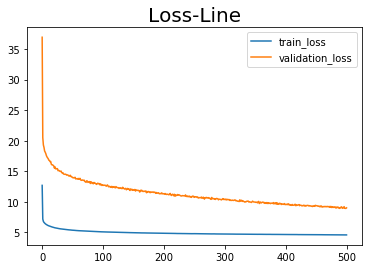

Wall time: 4min 1s


In [55]:
%%time
cnn = Network()
cnn.add(Conv1D(in_shape=(1,100),out_shape=(2, 98),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
#cnn.add(Conv1D(in_shape=(2, 98),out_shape=(4, 96),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
#cnn.add(Pooling1D(in_shape=(4,96), out_shape=(4,48)))
cnn.add(Flatten(in_shape=(2,98)))
cnn.add(FC(in_shape=196,out_shape=100, alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
cnn.add(FC(in_shape=100,out_shape=100, alpha=0.01, activation=LeakyReLU(a=1.), optimizer=Adagrad()))  #回帰なので恒等関数

cnn.fit(X_train_cnn,y_train,X_test_cnn,y_test,batch_size=20,n_epoch=500,ver=True)

In [51]:
print(cnn.model_list[0].w)

[[[0.06821    0.05979367 0.05445846]]

 [[0.05909379 0.05607127 0.08131782]]]


↓元のデータのノイズとノイズのない時系列データ


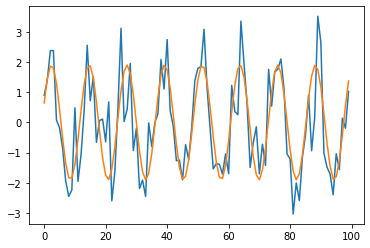

↓学習後のデータのノイズとノイズのない時系列データ


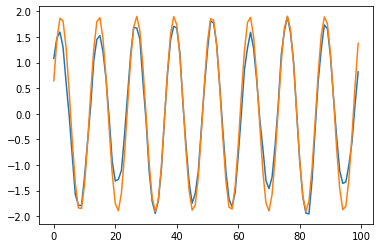

In [52]:
print("↓元のデータのノイズとノイズのない時系列データ")
plt.plot(X_test_cnn[0,0,:])
plt.plot(y_test[0])
plt.show()

y_predict_cnn = cnn.predict(X_test_cnn[:10])
print("↓学習後のデータのノイズとノイズのない時系列データ")
plt.plot(y_predict_cnn[0])
plt.plot(y_test[0])
plt.show()

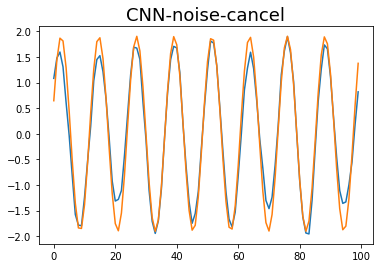

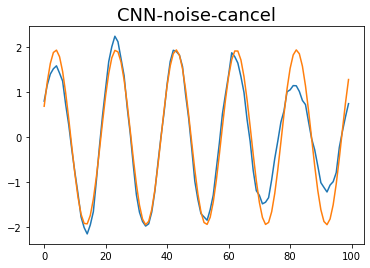

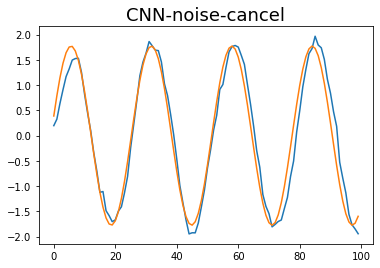

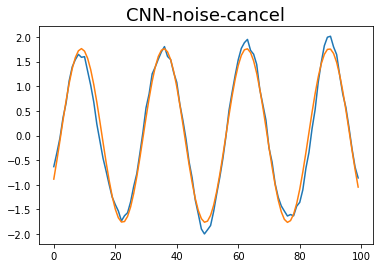

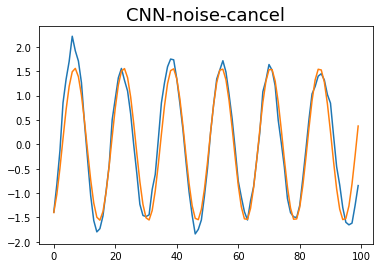

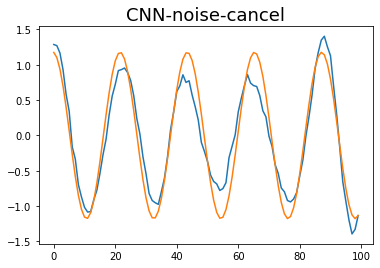

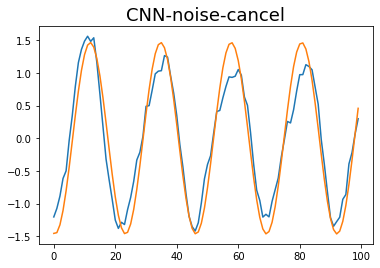

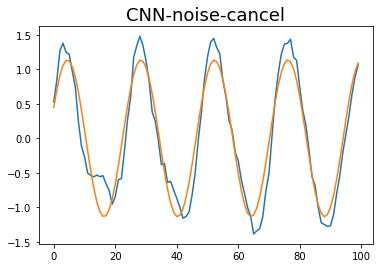

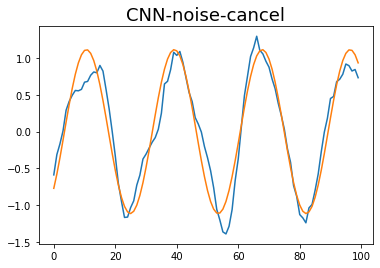

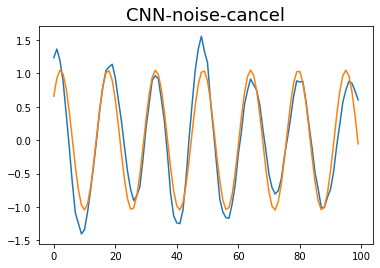

In [53]:
for i in range(10):
    #print("↓ノイズ除去結果(CNN)")
    plt.plot(y_predict_cnn[i],label="ノイズ除去")
    plt.plot(y_test[i],label="元のデータ")
    plt.title("CNN-noise-cancel",fontsize=18)
    plt.show()

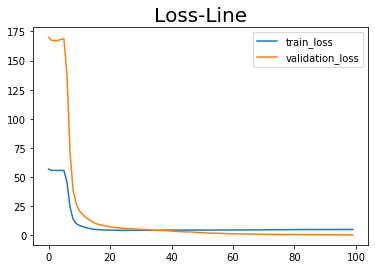

Wall time: 25min 22s


In [54]:
%%time
cnn2 = Network()
cnn2.add(Conv1D(in_shape=(1,100),out_shape=(2, 98),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
cnn2.add(Conv1D(in_shape=(2, 98),out_shape=(4, 96),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
cnn2.add(Pooling1D(in_shape=(4,96), out_shape=(4,48)))
cnn2.add(Conv1D(in_shape=(4, 48),out_shape=(8, 46),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
cnn2.add(Conv1D(in_shape=(8, 46),out_shape=(16, 44),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
cnn2.add(Pooling1D(in_shape=(16,44), out_shape=(16,22)))
cnn2.add(Conv1D(in_shape=(16, 22),out_shape=(32, 20),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
cnn2.add(Conv1D(in_shape=(32, 20),out_shape=(64, 18),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
cnn2.add(Pooling1D(in_shape=(64,18), out_shape=(64,9)))
cnn2.add(Conv1D(in_shape=(64, 9),out_shape=(128, 7),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
cnn2.add(Conv1D(in_shape=(128, 7),out_shape=(256, 5),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
cnn2.add(Conv1D(in_shape=(256, 5),out_shape=(512, 3),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
cnn2.add(Conv1D(in_shape=(512, 3),out_shape=(1024, 1),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
cnn2.add(Flatten(in_shape=(1024,1)))

cnn2.add(FC(in_shape=1024,out_shape=100, alpha=0.01, activation=LeakyReLU(a=1.), optimizer=Adagrad()))  #回帰なので恒等関数

cnn2.fit(X_train_cnn,y_train,X_test_cnn,y_test,batch_size=40,n_epoch=100,ver=True)

↓元のデータのノイズとノイズのない時系列データ


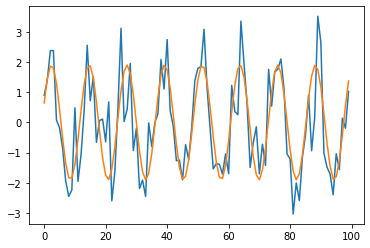

↓学習後のデータのノイズとノイズのない時系列データ


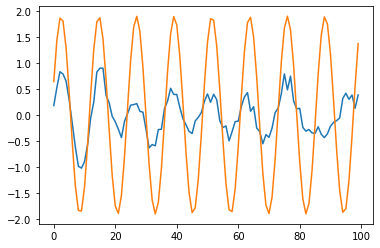

In [35]:
print("↓元のデータのノイズとノイズのない時系列データ")
plt.plot(X_test_cnn[0,0,:])
plt.plot(y_test[0])
plt.show()

y_predict_cnn2 = cnn2.predict(X_test_cnn[:10])
print("↓学習後のデータのノイズとノイズのない時系列データ")
plt.plot(y_predict_cnn2[0])
plt.plot(y_test[0])
plt.show()

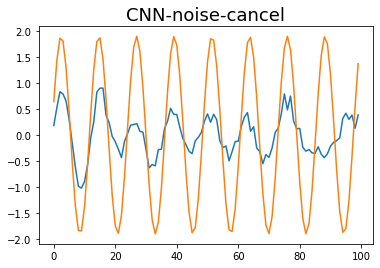

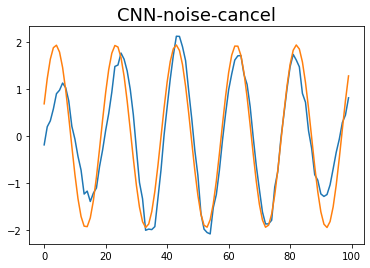

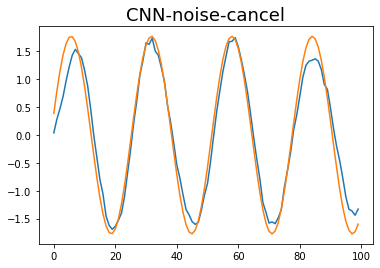

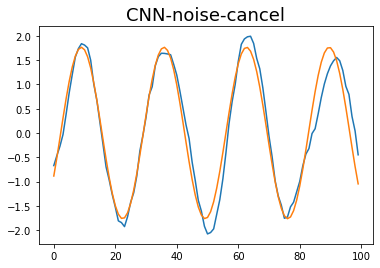

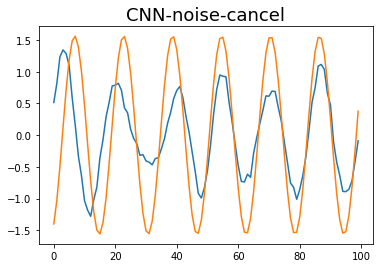

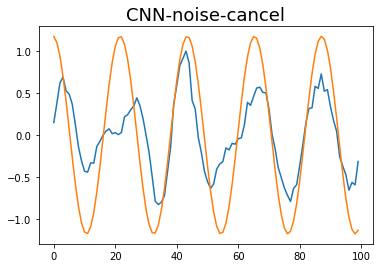

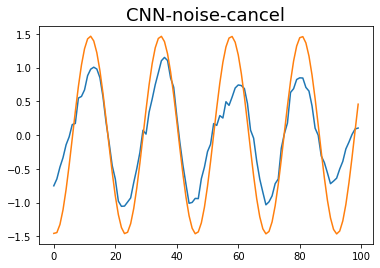

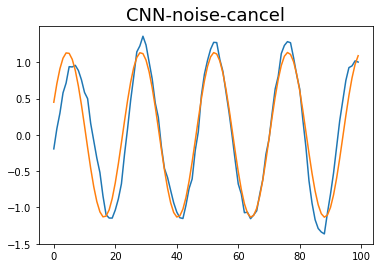

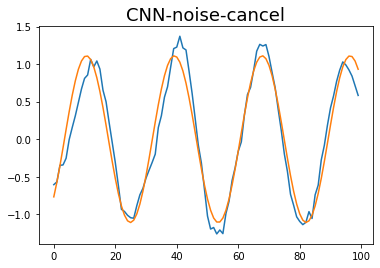

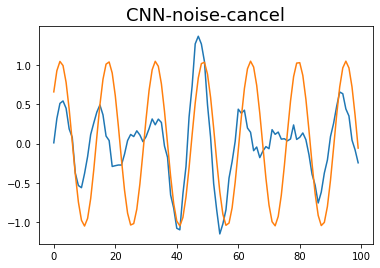

In [36]:
for i in range(10):
    #print("↓ノイズ除去結果(CNN)")
    plt.plot(y_predict_cnn2[i],label="ノイズ除去")
    plt.plot(y_test[i],label="元のデータ")
    plt.title("CNN-noise-cancel",fontsize=18)
    plt.show()

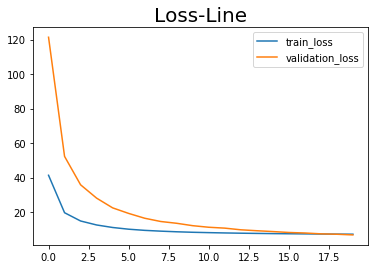

Wall time: 10.2 s


In [37]:
%%time
dnn = Network()
dnn.add(FC(in_shape=100, out_shape=100, alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
dnn.add(FC(in_shape=100, out_shape=100, alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
dnn.add(FC(in_shape=100, out_shape=100, alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
dnn.add(FC(in_shape=100, out_shape=100, alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
dnn.add(FC(in_shape=100, out_shape=100, alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
dnn.add(FC(in_shape=100, out_shape=100, alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad()))
dnn.add(FC(in_shape=100, out_shape=100, alpha=0.01, activation=LeakyReLU(a=0.5),optimizer=Adagrad()))
dnn.add(FC(in_shape=100, out_shape=100, alpha=0.01, activation=LeakyReLU(a=0.2),optimizer=Adagrad()))
dnn.add(FC(in_shape=100, out_shape=100, alpha=0.01, activation=LeakyReLU(a=1.), optimizer=Adagrad()))  #回帰なので恒等関数

dnn.fit(X_train,y_train,X_test,y_test,batch_size=40,n_epoch=20,ver=True)

↓元のデータのノイズとノイズのない時系列データ


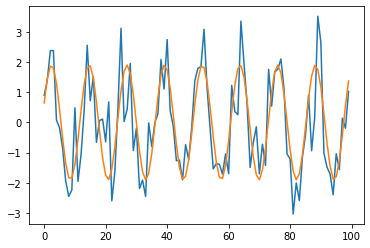

↓学習後のデータのノイズとノイズのない時系列データ


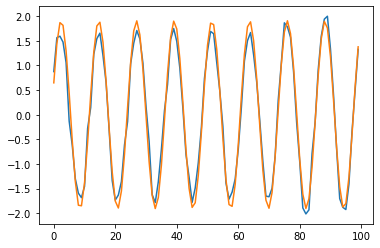

In [38]:
print("↓元のデータのノイズとノイズのない時系列データ")
plt.plot(X_test[0])
plt.plot(y_test[0])
plt.show()

y_predict_dnn = dnn.predict(X_test[:10])
print("↓学習後のデータのノイズとノイズのない時系列データ")
plt.plot(y_predict_dnn[0])
plt.plot(y_test[0])
plt.show()

↓ノイズ除去結果


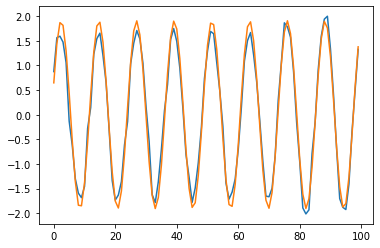

↓ノイズ除去結果


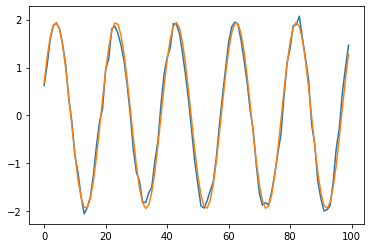

↓ノイズ除去結果


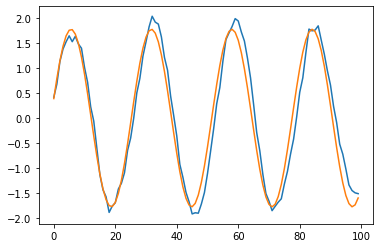

↓ノイズ除去結果


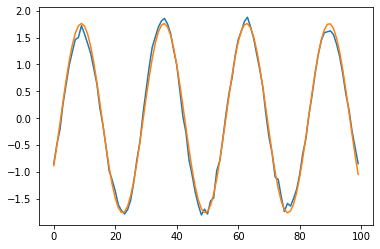

↓ノイズ除去結果


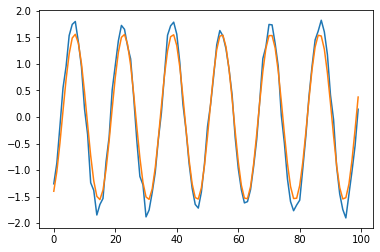

↓ノイズ除去結果


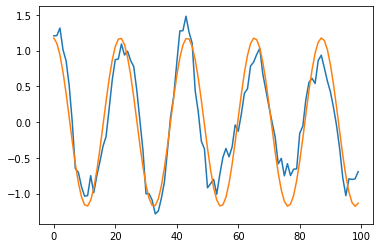

↓ノイズ除去結果


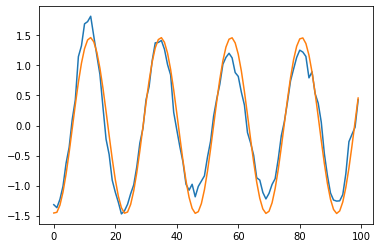

↓ノイズ除去結果


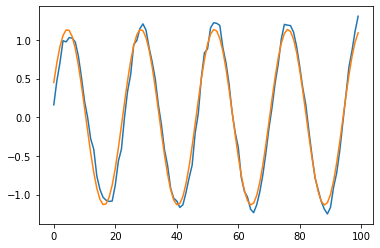

↓ノイズ除去結果


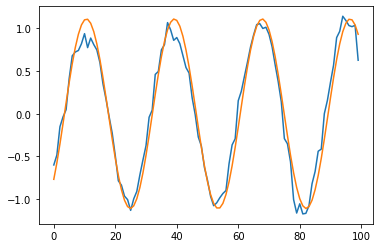

↓ノイズ除去結果


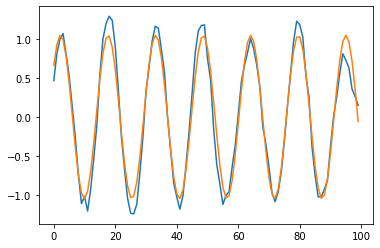

In [39]:
for i in range(10):
    print("↓ノイズ除去結果")
    plt.plot(y_predict_dnn[i])
    plt.plot(y_test[i])
    plt.show()

In [1]:
def 日本語で関数作れるよ(言葉１):
    出力 = print
    出力(言葉１)

In [2]:
日本語で関数作れるよ("可読性ヨシ！")

可読性ヨシ！
